# Random forest for classification 

Import packages

In [ ]:

# Data Processing
import pandas as pd
import numpy as np
import zipfile, io, urllib.request

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

Loading the dataset

In [ ]:

bank_data = pd.read_csv(io.BytesIO(zipfile.ZipFile(io.BytesIO(urllib.request.urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip').read())).read('bank-additional/bank-additional-full.csv')), sep=';')

Preprocessing data

In [7]:
bank_data['default'] = bank_data['default'].map({'yes':1, 'no': 0, 'unknown': 0})
bank_data['y'] = bank_data['y'].map({'yes': 1, 'no' : 0})

Splitting the Data

In [8]:
# Split the data into features (X) and target (y)
X = bank_data.drop('y', axis=1)
y = bank_data['y']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = X_train.select_dtypes(include=['object']).columns

for col in categorical_cols:
    le = LabelEncoder()
    # Fit on combined data to ensure consistent encoding
    combined_col = pd.concat([X_train[col], X_test[col]], axis=0)
    le.fit(combined_col.astype(str))
    
    # Transform both sets
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

Fitting and Evaluating the Random Forest Model

In [11]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# testing the model
y_pred =rf.predict(X_test)


In [12]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9145423646516144


Visualizing the Results

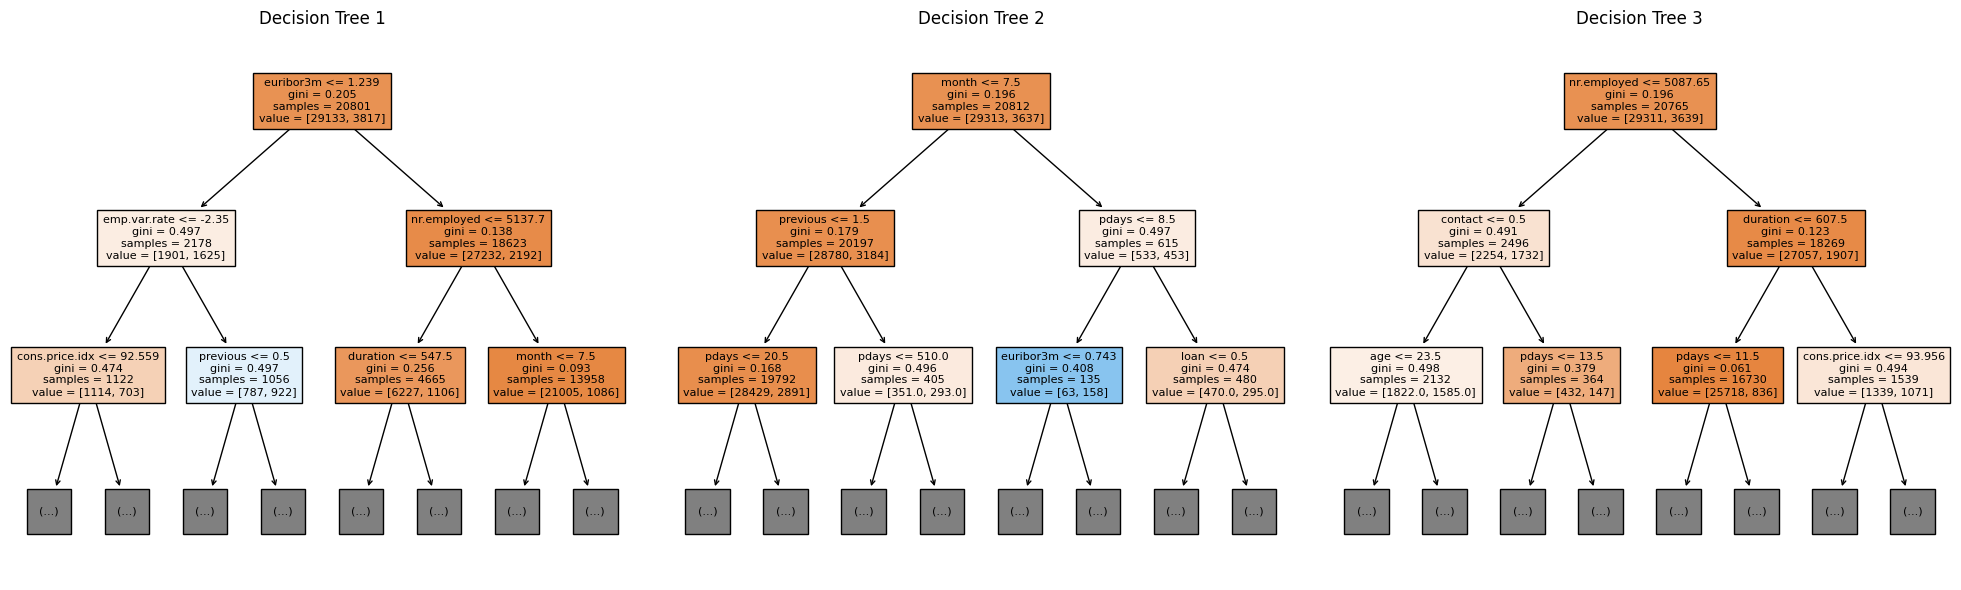

In [14]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Visualize first 3 trees using matplotlib (no Graphviz needed)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i in range(3):
    tree = rf.estimators_[i]
    plot_tree(tree, 
              ax=axes[i],
              feature_names=X_train.columns,
              filled=True,
              max_depth=2,
              fontsize=8)
    axes[i].set_title(f'Decision Tree {i+1}')

plt.tight_layout()
plt.show()

Hyperparameter Tuning

In [15]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020129311BD0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002012569F210>})

In [16]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 16, 'n_estimators': 373}


More Random Forest Evaluation Metrics

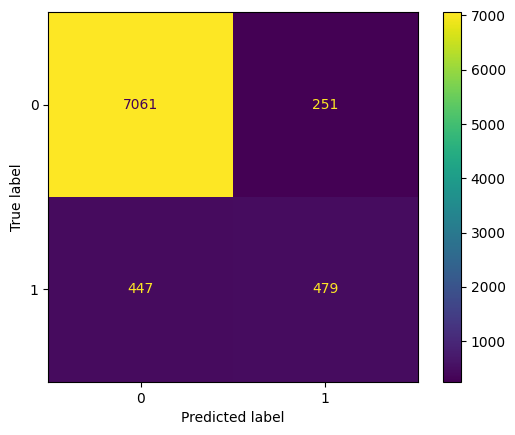

In [17]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Scale features (important for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Now your original code will work:
y_pred = knn.predict(X_test_scaled)  # Use scaled test data
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9015537751881525
Precision: 0.5908372827804107
Recall: 0.4038876889848812


Feature importance 

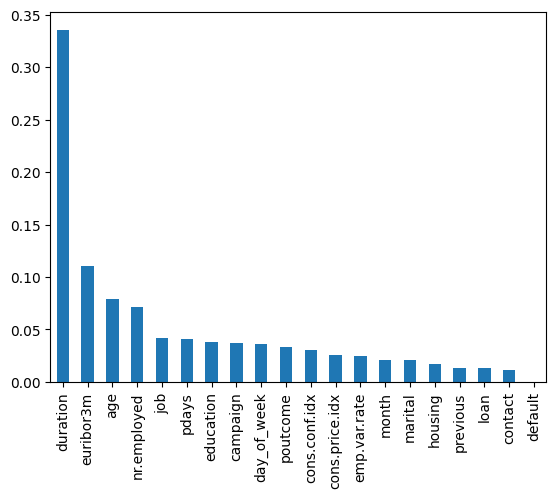

In [19]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

This tells us that the consumer confidence index, at the time of the call, was the biggest predictor of whether the person subscribed.